In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

## Data Preparation and Exploration

In [59]:
# Data Loading
df=pd.read_csv('exchange_rate.csv',index_col='date',parse_dates=['date'],dayfirst=True)
print(df.info())
print(df.head(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB
None
            Ex_rate
date               
1990-01-01   0.7855
1990-01-02   0.7818
1990-01-03   0.7867
1990-01-04   0.7860
1990-01-05   0.7849
1990-01-06   0.7866
1990-01-07   0.7886
1990-01-08   0.7910
1990-01-09   0.7939
1990-01-10   0.7894


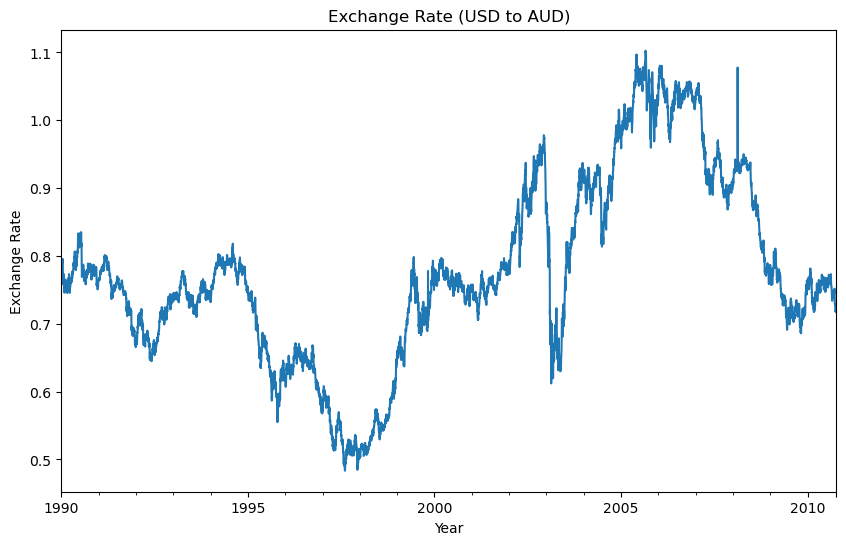

In [60]:
# Initial Exploration
#this to understand trends,seasonality and anomalies
df['Ex_rate'].plot(figsize=(10, 6), title="Exchange Rate (USD to AUD)", xlabel="Year", ylabel="Exchange Rate")
plt.show()


In [61]:
# Data Preprocessing

In [62]:
df.isna().sum()

Ex_rate    0
dtype: int64

In [63]:
# Remove anomalies (e.g., using Z-scores or domain knowledge)
from scipy.stats import zscore
df = df[(zscore(df['Ex_rate']) < 3)]

In [64]:
#df.index=pd.to_datetime(df.index)

In [65]:
#df.index = df.index.map(lambda x: x.date())

In [66]:
df

,Ex_rate
date,
1990-01-01,0.785500
1990-01-02,0.781800
1990-01-03,0.786700
1990-01-04,0.786000
1990-01-05,0.784900
...,...
2010-10-06,0.718494
2010-10-07,0.721839
2010-10-08,0.723197


In [67]:
df.index.freq='D'
df.index

DatetimeIndex(['1990-01-01', '1990-01-02', '1990-01-03', '1990-01-04',
               '1990-01-05', '1990-01-06', '1990-01-07', '1990-01-08',
               '1990-01-09', '1990-01-10',
               ...
               '2010-10-01', '2010-10-02', '2010-10-03', '2010-10-04',
               '2010-10-05', '2010-10-06', '2010-10-07', '2010-10-08',
               '2010-10-09', '2010-10-10'],
              dtype='datetime64[ns]', name='date', length=7588, freq='D')

## Model Building - ARIMA

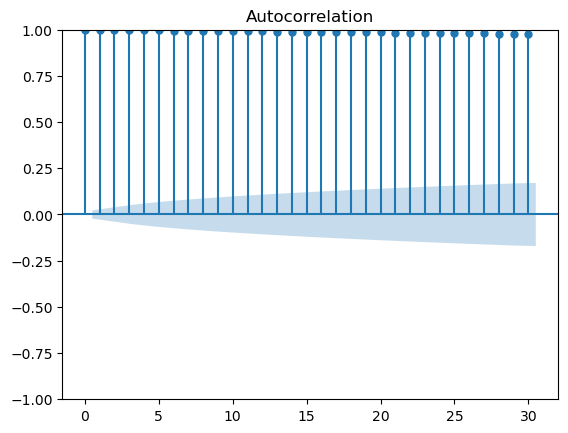

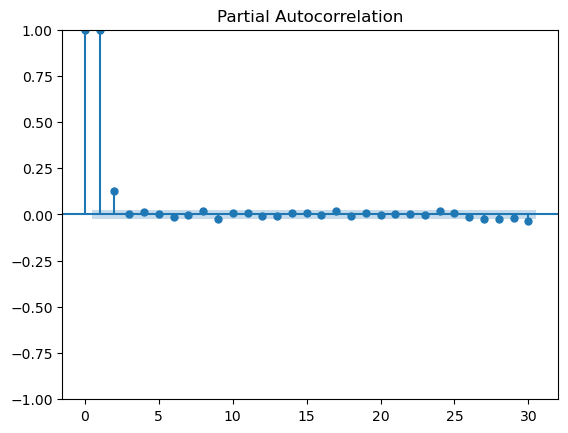

In [68]:
#Parameter Selection
#Plot ACF and PACF to estimate parameters

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Ex_rate'], lags=30)
plot_pacf(df['Ex_rate'], lags=30)
plt.show()

## Model Fitting

In [69]:
#Fit the ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Initial parameter estimates (p, d, q)
p, d, q = 3, 1, 0
arima_model = ARIMA(df['Ex_rate'], order=(p, d, q))
arima_result = arima_model.fit()

# Summary of the model
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(3, 1, 0)   Log Likelihood               28055.202
Date:                Thu, 02 Jan 2025   AIC                         -56102.403
Time:                        11:41:25   BIC                         -56074.666
Sample:                    01-01-1990   HQIC                        -56092.884
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1314      0.002    -64.017      0.000      -0.135      -0.127
ar.L2         -0.0027      0.006     -0.455      0.649      -0.014       0.009
ar.L3         -0.0166      0.007     -2.441      0.0

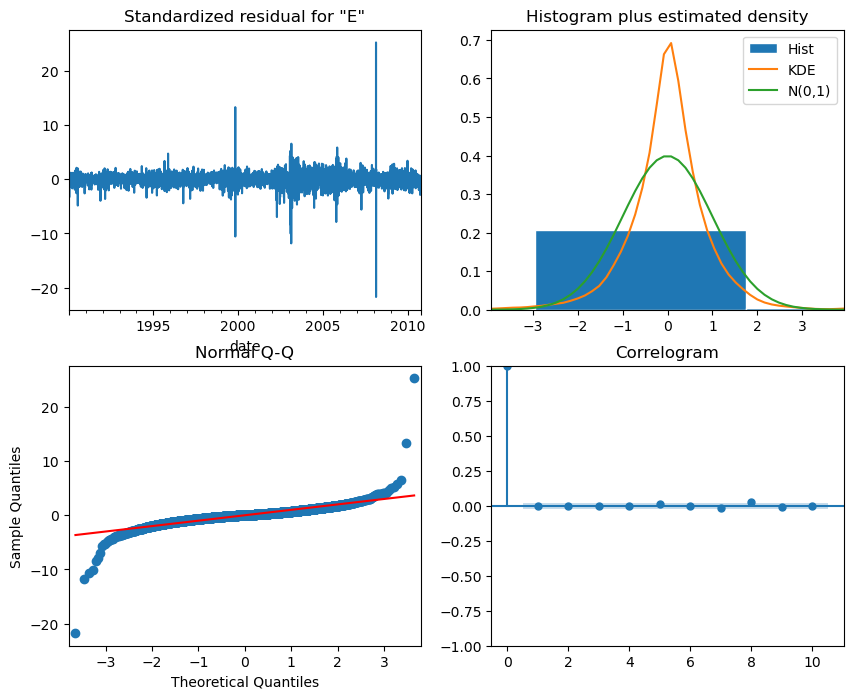

In [70]:
#Diagnostics
#Check residuals
arima_result.plot_diagnostics(figsize=(10, 8))
plt.show()

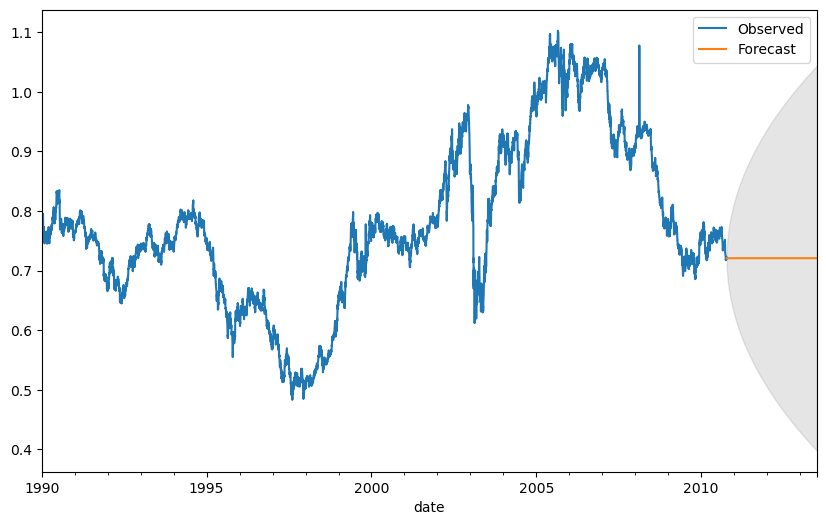

In [71]:
#Forecasting
#Forecast and visualize
forecast = arima_result.get_forecast(steps=1000)
forecast_ci = forecast.conf_int()

# Plot
df['Ex_rate'].plot(label='Observed', figsize=(10, 6))
forecast.predicted_mean.plot(label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)
plt.legend()
plt.show()


## Model Building - Exponential Smoothing

In [72]:
#Model Selection
#Choose an Exponential Smoothing model

In [73]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Holt-Winters method
exp_model = ExponentialSmoothing(df['Ex_rate'],trend= 'add', seasonal='add', seasonal_periods=365)
exp_result = exp_model.fit()


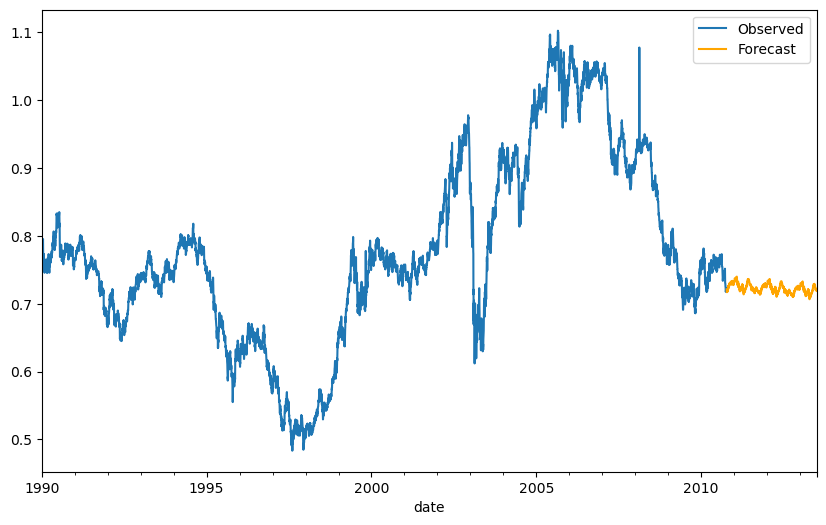

In [74]:
#Forecasting
#Forecast and visualize

forecast_exp = exp_result.forecast(steps=1000)

# Plot
df['Ex_rate'].plot(label='Observed', figsize=(10, 6))
forecast_exp.plot(label='Forecast', color='orange')
plt.legend()
plt.show()


## Evaluation and Comparison

In [75]:
#Error Metrics
#Compute MAE, RMSE, and MAPE

In [76]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ARIMA Errors
arima_mae = mean_absolute_error(df['Ex_rate'], arima_result.fittedvalues)
arima_rmse = mean_squared_error(df['Ex_rate'], arima_result.fittedvalues, squared=False)

# Exponential Smoothing Errors
exp_mae = mean_absolute_error(df['Ex_rate'], exp_result.fittedvalues)
exp_rmse = mean_squared_error(df['Ex_rate'], exp_result.fittedvalues, squared=False)

print(f"ARIMA MAE: {arima_mae}, RMSE: {arima_rmse}")
print(f"Exponential Smoothing MAE: {exp_mae}, RMSE: {exp_rmse}")


ARIMA MAE: 0.0037970074188942394, RMSE: 0.010828471182584553
Exponential Smoothing MAE: 0.003723325693189008, RMSE: 0.005862068049189667


In [77]:
#end
